In [1]:
import logging

from typing import Literal, List
from pydantic import BaseModel
from pydantic_ai import Agent
from dotenv import load_dotenv
import json
import nest_asyncio
from pydantic_ai.models.openai import OpenAIChatModel
from tenacity import stop_after_attempt

from httpx import AsyncClient, HTTPStatusError
from tenacity import retry_if_exception_type, wait_exponential

from pydantic_ai.retries import AsyncTenacityTransport, RetryConfig, wait_retry_after

nest_asyncio.apply()

load_dotenv()

True

In [2]:
class HyperParams(BaseModel):
    hidden_size: Literal[32, 64, 128, 256]
    n_head: Literal[4, 8, 16]
    dropout: Literal[0, 0.05, 0.1, 0.2, 0.3, 0.4, 0.5]
    conv_hidden_size: Literal[8, 16, 32, 64]
    distil: Literal[True, False]
    activation: Literal["relu", "gelu"]
    encoder_layers: Literal[1, 2, 3, 4, 6]
    decoder_layers: Literal[1, 2]
    learning_rate: Literal[1e-4]
    scaler_type: Literal["robust"]
    max_steps: Literal[8]
    val_check_steps: Literal[8]
    batch_size: Literal[32]
    windows_batch_size: Literal[1024]
    random_seed: Literal[1]


class HistoryEntry(BaseModel):
    params: HyperParams
    metric: float


class SuggestionInput(BaseModel):
    optimize_direction: Literal["minimize", "maximize"] = "minimize"
    history: List[HistoryEntry] | None = None


def create_retrying_client():
    """Create a client with smart retry handling for multiple error types."""

    def should_retry_status(response):
        """Raise exceptions for retryable HTTP status codes."""
        if response.status_code in (429, 403, 502, 503, 504):
            response.raise_for_status()  # This will raise HTTPStatusError

    transport = AsyncTenacityTransport(
        config=RetryConfig(
            # Retry on HTTP errors and connection issues
            retry=retry_if_exception_type((HTTPStatusError, ConnectionError)),
            # Smart waiting: respects Retry-After headers, falls back to exponential backoff
            wait=wait_retry_after(
                fallback_strategy=wait_exponential(multiplier=1, max=60), max_wait=300
            ),
            # Stop after 5 attempts
            stop=stop_after_attempt(5),
            # Re-raise the last exception if all retries fail
            reraise=True,
        ),
        validate_response=should_retry_status,
    )
    return AsyncClient(transport=transport)


# Use the retrying client with a model
client = create_retrying_client()

model = OpenAIChatModel(
    "qwen/qwen3-8b",
)

agent = Agent(
    model=model,
    instructions=(
        "You are an AutoML hyperparameter optimization expert. "
        "You receive:\n"
        " - history of tried parameters with metric\n"
        " - optimization direction\n"
        " - fixed categorical hyperparameter search space\n\n"
        "Your task:\n"
        " - analyze the history\n"
        " - choose the next promising point strictly inside the allowed search space\n"
        " - DO NOT repeat params from history\n"
    ),
    output_type=HyperParams,
)


def suggest_params_with_history(
    *,
    optimize_direction: Literal["minimize", "maximize"] = "minimize",
    history: list | None = None,
):
    history_text = (
        json.dumps([h for h in history], ensure_ascii=False, indent=2)
        if history
        else "[]"
    )

    result = agent.run_sync(
        user_prompt=(
            "Suggest the next hyperparameter configuration based on:\n"
            f"Optimization direction: {optimize_direction}\n\n"
            f"History:\n{history_text}\n\n"
            "Return parameters strictly from the allowed categorical space."
        ),
    )

    return result.output

In [3]:
from datasetsforecast.long_horizon2 import LongHorizon2
import pandas as pd
from neuralforecast import NeuralForecast
from neuralforecast.auto import Informer
from neuralforecast.losses.pytorch import MSE
from neuralforecast.losses.numpy import mse
import torch
import matplotlib.pyplot as plt

logging.getLogger("pytorch_lightning").setLevel(logging.ERROR)

torch.set_float32_matmul_precision("high")


/root/NAS-LLM-Agent/.venv/lib/python3.13/site-packages/torch/__init__.py:1617: UserWarning: Please use the new API settings to control TF32 behavior, such as torch.backends.cudnn.conv.fp32_precision = 'tf32' or torch.backends.cuda.matmul.fp32_precision = 'ieee'. Old settings, e.g, torch.backends.cuda.matmul.allow_tf32 = True, torch.backends.cudnn.allow_tf32 = True, allowTF32CuDNN() and allowTF32CuBLAS() will be deprecated after Pytorch 2.9. Please see https://pytorch.org/docs/main/notes/cuda.html#tensorfloat-32-tf32-on-ampere-and-later-devices (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:80.)
  _C._set_float32_matmul_precision(precision)


In [4]:
def train_agent(dataset_group: str = "ETTh1", num_samples=25, horizon = 168):
    Y_df = LongHorizon2.load(directory="data", group=dataset_group)
    Y_df["ds"] = pd.to_datetime(Y_df["ds"])

    n_time = len(Y_df.ds.unique())
    val_size = int(0.2 * n_time)
    test_size = int(0.2 * n_time)

    optimize_direction = "minimize"
    history = []

    best_metric = float("inf")
    best_params = None

    for trial in range(num_samples):
        print(f"=== Trial {trial + 1} ===")

        # Suggest new hyperparameters
        new_params = suggest_params_with_history(
            optimize_direction=optimize_direction,
            history=history,
        )

        # Train Informer with suggested parameters
        nf = NeuralForecast(
            models=[
                Informer(h=horizon, loss=MSE(), input_size=horizon, **dict(new_params))
            ],
            freq="h",
        )
        _ = nf.cross_validation(
            df=Y_df, val_size=val_size, test_size=test_size, n_windows=None
        )

        metric_value = nf.models[0].metrics["ptl/val_loss"].item()

        print(
            f"Trial {trial + 1} finished with value: {metric_value:.4f} and parameters: {new_params}"
        )

        # Update best if improved
        if metric_value < best_metric:
            best_metric = metric_value
            best_params = dict(new_params)

        # Append to history
        history.append({"params": dict(new_params), "metric": metric_value})

    print(f"=== Best hyperparameters after {num_samples} trials ===")
    print(best_params)
    print(f"Best metric: {best_metric:.4f}")

    nf = NeuralForecast(models=[Informer(h=horizon, input_size=horizon, loss=MSE(), **best_params)], freq="h")
    Y_hat_df = nf.cross_validation(
        df=Y_df, val_size=val_size, test_size=test_size, n_windows=None
    )

    Y_plot = Y_hat_df[Y_hat_df["unique_id"] == "OT"]  # OT dataset
    cutoffs = Y_hat_df["cutoff"].unique()[::horizon]
    Y_plot = Y_plot[Y_hat_df["cutoff"].isin(cutoffs)]

    plt.figure(figsize=(20, 5))
    plt.plot(Y_plot["ds"], Y_plot["y"], label="True")
    plt.plot(Y_plot["ds"], Y_plot["Informer"], label="Informer")
    plt.xlabel("Datestamp")
    plt.ylabel("OT")
    plt.grid()
    plt.legend()

    mse_informer = mse(Y_hat_df["y"], Y_hat_df["Informer"])

    print(f"Informer: {mse_informer:.3f}")
    return nf, Y_hat_df

=== Trial 1 ===


INFO:httpx:HTTP Request: POST http://10.45.224.85:1234/v1/chat/completions "HTTP/1.1 200 OK"
INFO:lightning_fabric.utilities.seed:Seed set to 1


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

Trial 1 finished with value: 1.2899 and parameters: hidden_size=128 n_head=8 dropout=0.1 conv_hidden_size=32 distil=False activation='relu' encoder_layers=3 decoder_layers=2 learning_rate=0.0001 scaler_type='robust' max_steps=8 val_check_steps=8 batch_size=32 windows_batch_size=1024 random_seed=1
=== Trial 2 ===


INFO:httpx:HTTP Request: POST http://10.45.224.85:1234/v1/chat/completions "HTTP/1.1 200 OK"
INFO:lightning_fabric.utilities.seed:Seed set to 1


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

Trial 2 finished with value: 1.2558 and parameters: hidden_size=64 n_head=4 dropout=0.2 conv_hidden_size=16 distil=True activation='gelu' encoder_layers=2 decoder_layers=1 learning_rate=0.0001 scaler_type='robust' max_steps=8 val_check_steps=8 batch_size=32 windows_batch_size=1024 random_seed=1
=== Trial 3 ===


INFO:httpx:HTTP Request: POST http://10.45.224.85:1234/v1/chat/completions "HTTP/1.1 200 OK"
INFO:lightning_fabric.utilities.seed:Seed set to 1


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

Trial 3 finished with value: 1.3283 and parameters: hidden_size=32 n_head=16 dropout=0.05 conv_hidden_size=64 distil=False activation='gelu' encoder_layers=1 decoder_layers=2 learning_rate=0.0001 scaler_type='robust' max_steps=8 val_check_steps=8 batch_size=32 windows_batch_size=1024 random_seed=1
=== Trial 4 ===


INFO:httpx:HTTP Request: POST http://10.45.224.85:1234/v1/chat/completions "HTTP/1.1 200 OK"
INFO:lightning_fabric.utilities.seed:Seed set to 1


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

Trial 4 finished with value: 1.2379 and parameters: hidden_size=256 n_head=4 dropout=0.3 conv_hidden_size=8 distil=True activation='relu' encoder_layers=4 decoder_layers=1 learning_rate=0.0001 scaler_type='robust' max_steps=8 val_check_steps=8 batch_size=32 windows_batch_size=1024 random_seed=1
=== Trial 5 ===


INFO:httpx:HTTP Request: POST http://10.45.224.85:1234/v1/chat/completions "HTTP/1.1 200 OK"
INFO:lightning_fabric.utilities.seed:Seed set to 1


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

Trial 5 finished with value: 1.3722 and parameters: hidden_size=64 n_head=16 dropout=0.1 conv_hidden_size=32 distil=False activation='relu' encoder_layers=2 decoder_layers=1 learning_rate=0.0001 scaler_type='robust' max_steps=8 val_check_steps=8 batch_size=32 windows_batch_size=1024 random_seed=1
=== Trial 6 ===


INFO:httpx:HTTP Request: POST http://10.45.224.85:1234/v1/chat/completions "HTTP/1.1 200 OK"
INFO:lightning_fabric.utilities.seed:Seed set to 1


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

Trial 6 finished with value: 1.2485 and parameters: hidden_size=128 n_head=4 dropout=0.2 conv_hidden_size=64 distil=True activation='relu' encoder_layers=1 decoder_layers=2 learning_rate=0.0001 scaler_type='robust' max_steps=8 val_check_steps=8 batch_size=32 windows_batch_size=1024 random_seed=1
=== Trial 7 ===


INFO:httpx:HTTP Request: POST http://10.45.224.85:1234/v1/chat/completions "HTTP/1.1 200 OK"
INFO:lightning_fabric.utilities.seed:Seed set to 1


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

Trial 7 finished with value: 1.2506 and parameters: hidden_size=256 n_head=8 dropout=0.05 conv_hidden_size=16 distil=False activation='gelu' encoder_layers=4 decoder_layers=2 learning_rate=0.0001 scaler_type='robust' max_steps=8 val_check_steps=8 batch_size=32 windows_batch_size=1024 random_seed=1
=== Trial 8 ===


INFO:httpx:HTTP Request: POST http://10.45.224.85:1234/v1/chat/completions "HTTP/1.1 200 OK"
INFO:lightning_fabric.utilities.seed:Seed set to 1


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

Trial 8 finished with value: 1.2351 and parameters: hidden_size=128 n_head=4 dropout=0.1 conv_hidden_size=32 distil=False activation='gelu' encoder_layers=3 decoder_layers=1 learning_rate=0.0001 scaler_type='robust' max_steps=8 val_check_steps=8 batch_size=32 windows_batch_size=1024 random_seed=1
=== Trial 9 ===


INFO:httpx:HTTP Request: POST http://10.45.224.85:1234/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST http://10.45.224.85:1234/v1/chat/completions "HTTP/1.1 200 OK"
INFO:lightning_fabric.utilities.seed:Seed set to 1


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

Trial 9 finished with value: 1.3577 and parameters: hidden_size=64 n_head=8 dropout=0.2 conv_hidden_size=32 distil=False activation='relu' encoder_layers=2 decoder_layers=1 learning_rate=0.0001 scaler_type='robust' max_steps=8 val_check_steps=8 batch_size=32 windows_batch_size=1024 random_seed=1
=== Trial 10 ===


INFO:httpx:HTTP Request: POST http://10.45.224.85:1234/v1/chat/completions "HTTP/1.1 200 OK"
INFO:lightning_fabric.utilities.seed:Seed set to 1


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

Trial 10 finished with value: 1.3107 and parameters: hidden_size=64 n_head=8 dropout=0.1 conv_hidden_size=32 distil=True activation='relu' encoder_layers=4 decoder_layers=2 learning_rate=0.0001 scaler_type='robust' max_steps=8 val_check_steps=8 batch_size=32 windows_batch_size=1024 random_seed=1
=== Trial 11 ===


INFO:httpx:HTTP Request: POST http://10.45.224.85:1234/v1/chat/completions "HTTP/1.1 200 OK"
INFO:lightning_fabric.utilities.seed:Seed set to 1


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

Trial 11 finished with value: 1.3539 and parameters: hidden_size=32 n_head=4 dropout=0.1 conv_hidden_size=64 distil=False activation='relu' encoder_layers=3 decoder_layers=2 learning_rate=0.0001 scaler_type='robust' max_steps=8 val_check_steps=8 batch_size=32 windows_batch_size=1024 random_seed=1
=== Trial 12 ===


INFO:httpx:HTTP Request: POST http://10.45.224.85:1234/v1/chat/completions "HTTP/1.1 200 OK"
INFO:lightning_fabric.utilities.seed:Seed set to 1


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

Trial 12 finished with value: 1.2349 and parameters: hidden_size=128 n_head=4 dropout=0.2 conv_hidden_size=32 distil=False activation='gelu' encoder_layers=3 decoder_layers=1 learning_rate=0.0001 scaler_type='robust' max_steps=8 val_check_steps=8 batch_size=32 windows_batch_size=1024 random_seed=1
=== Trial 13 ===


INFO:httpx:HTTP Request: POST http://10.45.224.85:1234/v1/chat/completions "HTTP/1.1 200 OK"
INFO:lightning_fabric.utilities.seed:Seed set to 1


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

Trial 13 finished with value: 1.2733 and parameters: hidden_size=256 n_head=16 dropout=0.2 conv_hidden_size=32 distil=False activation='relu' encoder_layers=4 decoder_layers=2 learning_rate=0.0001 scaler_type='robust' max_steps=8 val_check_steps=8 batch_size=32 windows_batch_size=1024 random_seed=1
=== Trial 14 ===


INFO:httpx:HTTP Request: POST http://10.45.224.85:1234/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST http://10.45.224.85:1234/v1/chat/completions "HTTP/1.1 200 OK"
INFO:lightning_fabric.utilities.seed:Seed set to 1


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

Trial 14 finished with value: 1.3910 and parameters: hidden_size=32 n_head=8 dropout=0.1 conv_hidden_size=16 distil=True activation='gelu' encoder_layers=2 decoder_layers=1 learning_rate=0.0001 scaler_type='robust' max_steps=8 val_check_steps=8 batch_size=32 windows_batch_size=1024 random_seed=1
=== Trial 15 ===


INFO:httpx:HTTP Request: POST http://10.45.224.85:1234/v1/chat/completions "HTTP/1.1 200 OK"
INFO:lightning_fabric.utilities.seed:Seed set to 1


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

Trial 15 finished with value: 1.2907 and parameters: hidden_size=128 n_head=8 dropout=0.1 conv_hidden_size=32 distil=False activation='gelu' encoder_layers=3 decoder_layers=2 learning_rate=0.0001 scaler_type='robust' max_steps=8 val_check_steps=8 batch_size=32 windows_batch_size=1024 random_seed=1
=== Trial 16 ===


INFO:httpx:HTTP Request: POST http://10.45.224.85:1234/v1/chat/completions "HTTP/1.1 200 OK"
INFO:lightning_fabric.utilities.seed:Seed set to 1


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

Trial 16 finished with value: 1.2699 and parameters: hidden_size=256 n_head=16 dropout=0.05 conv_hidden_size=32 distil=False activation='gelu' encoder_layers=4 decoder_layers=2 learning_rate=0.0001 scaler_type='robust' max_steps=8 val_check_steps=8 batch_size=32 windows_batch_size=1024 random_seed=1
=== Trial 17 ===


INFO:httpx:HTTP Request: POST http://10.45.224.85:1234/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST http://10.45.224.85:1234/v1/chat/completions "HTTP/1.1 200 OK"
INFO:lightning_fabric.utilities.seed:Seed set to 1


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

Trial 17 finished with value: 1.2389 and parameters: hidden_size=128 n_head=4 dropout=0.1 conv_hidden_size=64 distil=True activation='gelu' encoder_layers=2 decoder_layers=1 learning_rate=0.0001 scaler_type='robust' max_steps=8 val_check_steps=8 batch_size=32 windows_batch_size=1024 random_seed=1
=== Trial 18 ===


INFO:httpx:HTTP Request: POST http://10.45.224.85:1234/v1/chat/completions "HTTP/1.1 200 OK"
INFO:lightning_fabric.utilities.seed:Seed set to 1


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

Trial 18 finished with value: 1.2560 and parameters: hidden_size=128 n_head=4 dropout=0.1 conv_hidden_size=32 distil=False activation='gelu' encoder_layers=3 decoder_layers=2 learning_rate=0.0001 scaler_type='robust' max_steps=8 val_check_steps=8 batch_size=32 windows_batch_size=1024 random_seed=1
=== Trial 19 ===


INFO:httpx:HTTP Request: POST http://10.45.224.85:1234/v1/chat/completions "HTTP/1.1 200 OK"
INFO:lightning_fabric.utilities.seed:Seed set to 1


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

Trial 19 finished with value: 1.2841 and parameters: hidden_size=256 n_head=16 dropout=0.1 conv_hidden_size=32 distil=False activation='relu' encoder_layers=4 decoder_layers=1 learning_rate=0.0001 scaler_type='robust' max_steps=8 val_check_steps=8 batch_size=32 windows_batch_size=1024 random_seed=1
=== Trial 20 ===


INFO:httpx:HTTP Request: POST http://10.45.224.85:1234/v1/chat/completions "HTTP/1.1 200 OK"
INFO:lightning_fabric.utilities.seed:Seed set to 1


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

Trial 20 finished with value: 1.3628 and parameters: hidden_size=32 n_head=16 dropout=0.2 conv_hidden_size=32 distil=False activation='relu' encoder_layers=4 decoder_layers=1 learning_rate=0.0001 scaler_type='robust' max_steps=8 val_check_steps=8 batch_size=32 windows_batch_size=1024 random_seed=1
=== Trial 21 ===


INFO:httpx:HTTP Request: POST http://10.45.224.85:1234/v1/chat/completions "HTTP/1.1 200 OK"
INFO:lightning_fabric.utilities.seed:Seed set to 1


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

Trial 21 finished with value: 1.2841 and parameters: hidden_size=256 n_head=16 dropout=0.1 conv_hidden_size=32 distil=False activation='relu' encoder_layers=4 decoder_layers=1 learning_rate=0.0001 scaler_type='robust' max_steps=8 val_check_steps=8 batch_size=32 windows_batch_size=1024 random_seed=1
=== Trial 22 ===


INFO:httpx:HTTP Request: POST http://10.45.224.85:1234/v1/chat/completions "HTTP/1.1 200 OK"
INFO:lightning_fabric.utilities.seed:Seed set to 1


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

Trial 22 finished with value: 1.4563 and parameters: hidden_size=64 n_head=8 dropout=0.1 conv_hidden_size=16 distil=False activation='relu' encoder_layers=2 decoder_layers=1 learning_rate=0.0001 scaler_type='robust' max_steps=8 val_check_steps=8 batch_size=32 windows_batch_size=1024 random_seed=1
=== Trial 23 ===


INFO:httpx:HTTP Request: POST http://10.45.224.85:1234/v1/chat/completions "HTTP/1.1 200 OK"
INFO:lightning_fabric.utilities.seed:Seed set to 1


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

Trial 23 finished with value: 1.2560 and parameters: hidden_size=128 n_head=4 dropout=0.1 conv_hidden_size=32 distil=False activation='gelu' encoder_layers=3 decoder_layers=2 learning_rate=0.0001 scaler_type='robust' max_steps=8 val_check_steps=8 batch_size=32 windows_batch_size=1024 random_seed=1
=== Trial 24 ===


INFO:httpx:HTTP Request: POST http://10.45.224.85:1234/v1/chat/completions "HTTP/1.1 200 OK"
INFO:lightning_fabric.utilities.seed:Seed set to 1


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

Trial 24 finished with value: 1.3399 and parameters: hidden_size=32 n_head=4 dropout=0.1 conv_hidden_size=32 distil=False activation='relu' encoder_layers=4 decoder_layers=1 learning_rate=0.0001 scaler_type='robust' max_steps=8 val_check_steps=8 batch_size=32 windows_batch_size=1024 random_seed=1
=== Trial 25 ===


INFO:httpx:HTTP Request: POST http://10.45.224.85:1234/v1/chat/completions "HTTP/1.1 200 OK"
INFO:lightning_fabric.utilities.seed:Seed set to 1


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

INFO:lightning_fabric.utilities.seed:Seed set to 1


Trial 25 finished with value: 1.2925 and parameters: hidden_size=256 n_head=16 dropout=0.3 conv_hidden_size=8 distil=False activation='relu' encoder_layers=4 decoder_layers=1 learning_rate=0.0001 scaler_type='robust' max_steps=8 val_check_steps=8 batch_size=32 windows_batch_size=1024 random_seed=1
=== Best hyperparameters after 25 trials ===
{'hidden_size': 128, 'n_head': 4, 'dropout': 0.2, 'conv_hidden_size': 32, 'distil': False, 'activation': 'gelu', 'encoder_layers': 3, 'decoder_layers': 1, 'learning_rate': 0.0001, 'scaler_type': 'robust', 'max_steps': 8, 'val_check_steps': 8, 'batch_size': 32, 'windows_batch_size': 1024, 'random_seed': 1}
Best metric: 1.2349


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

/tmp/ipykernel_14809/2368380654.py:60: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  Y_plot = Y_plot[Y_hat_df["cutoff"].isin(cutoffs)]


Informer: 0.612


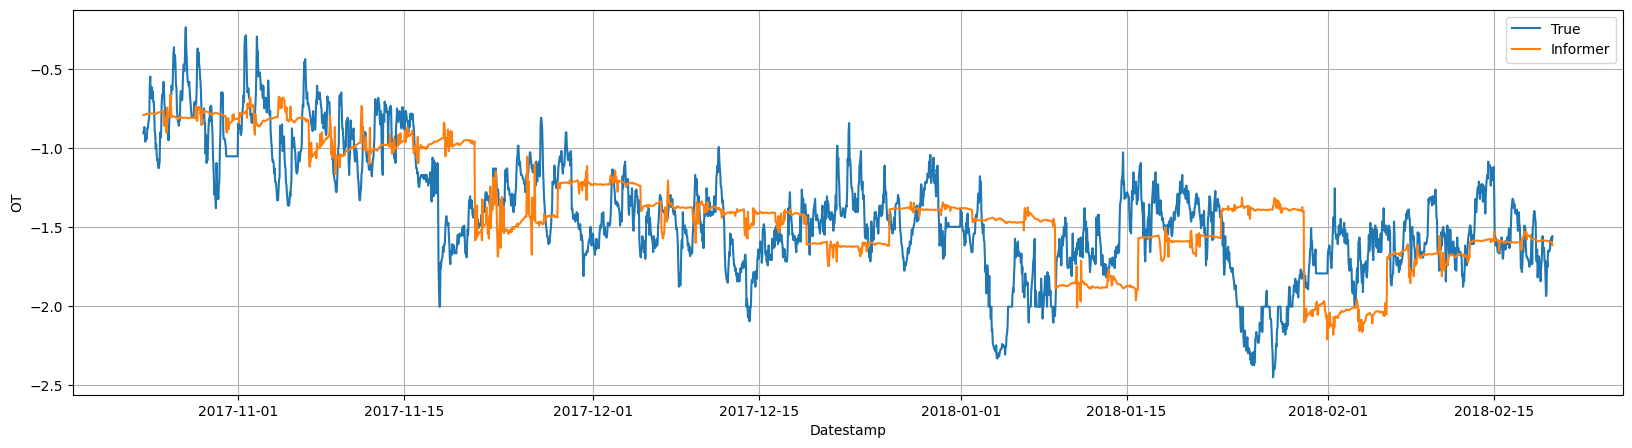

In [5]:
nf, Y_hat_df = train_agent(dataset_group="ETTh1")

=== Trial 1 ===


INFO:httpx:HTTP Request: POST http://10.45.224.85:1234/v1/chat/completions "HTTP/1.1 200 OK"
INFO:lightning_fabric.utilities.seed:Seed set to 1


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

Trial 1 finished with value: 0.3489 and parameters: hidden_size=128 n_head=8 dropout=0.1 conv_hidden_size=32 distil=False activation='relu' encoder_layers=3 decoder_layers=2 learning_rate=0.0001 scaler_type='robust' max_steps=8 val_check_steps=8 batch_size=32 windows_batch_size=1024 random_seed=1
=== Trial 2 ===


INFO:httpx:HTTP Request: POST http://10.45.224.85:1234/v1/chat/completions "HTTP/1.1 200 OK"
INFO:lightning_fabric.utilities.seed:Seed set to 1


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

Trial 2 finished with value: 0.2848 and parameters: hidden_size=64 n_head=16 dropout=0.2 conv_hidden_size=16 distil=True activation='gelu' encoder_layers=2 decoder_layers=1 learning_rate=0.0001 scaler_type='robust' max_steps=8 val_check_steps=8 batch_size=32 windows_batch_size=1024 random_seed=1
=== Trial 3 ===


INFO:httpx:HTTP Request: POST http://10.45.224.85:1234/v1/chat/completions "HTTP/1.1 200 OK"
INFO:lightning_fabric.utilities.seed:Seed set to 1


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

Trial 3 finished with value: 0.2861 and parameters: hidden_size=32 n_head=4 dropout=0.05 conv_hidden_size=64 distil=False activation='gelu' encoder_layers=1 decoder_layers=2 learning_rate=0.0001 scaler_type='robust' max_steps=8 val_check_steps=8 batch_size=32 windows_batch_size=1024 random_seed=1
=== Trial 4 ===


INFO:httpx:HTTP Request: POST http://10.45.224.85:1234/v1/chat/completions "HTTP/1.1 200 OK"
INFO:lightning_fabric.utilities.seed:Seed set to 1


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

Trial 4 finished with value: 0.3545 and parameters: hidden_size=256 n_head=16 dropout=0.3 conv_hidden_size=8 distil=True activation='relu' encoder_layers=4 decoder_layers=1 learning_rate=0.0001 scaler_type='robust' max_steps=8 val_check_steps=8 batch_size=32 windows_batch_size=1024 random_seed=1
=== Trial 5 ===


INFO:httpx:HTTP Request: POST http://10.45.224.85:1234/v1/chat/completions "HTTP/1.1 200 OK"
INFO:lightning_fabric.utilities.seed:Seed set to 1


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

Trial 5 finished with value: 0.3134 and parameters: hidden_size=128 n_head=4 dropout=0.2 conv_hidden_size=64 distil=False activation='relu' encoder_layers=2 decoder_layers=1 learning_rate=0.0001 scaler_type='robust' max_steps=8 val_check_steps=8 batch_size=32 windows_batch_size=1024 random_seed=1
=== Trial 6 ===


INFO:httpx:HTTP Request: POST http://10.45.224.85:1234/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST http://10.45.224.85:1234/v1/chat/completions "HTTP/1.1 200 OK"
INFO:lightning_fabric.utilities.seed:Seed set to 1


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

Trial 6 finished with value: 0.2959 and parameters: hidden_size=64 n_head=8 dropout=0.1 conv_hidden_size=32 distil=False activation='relu' encoder_layers=4 decoder_layers=2 learning_rate=0.0001 scaler_type='robust' max_steps=8 val_check_steps=8 batch_size=32 windows_batch_size=1024 random_seed=1
=== Trial 7 ===


INFO:httpx:HTTP Request: POST http://10.45.224.85:1234/v1/chat/completions "HTTP/1.1 200 OK"
INFO:lightning_fabric.utilities.seed:Seed set to 1


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

Trial 7 finished with value: 0.4784 and parameters: hidden_size=256 n_head=4 dropout=0.1 conv_hidden_size=16 distil=False activation='gelu' encoder_layers=1 decoder_layers=1 learning_rate=0.0001 scaler_type='robust' max_steps=8 val_check_steps=8 batch_size=32 windows_batch_size=1024 random_seed=1
=== Trial 8 ===


INFO:httpx:HTTP Request: POST http://10.45.224.85:1234/v1/chat/completions "HTTP/1.1 200 OK"
INFO:lightning_fabric.utilities.seed:Seed set to 1


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

Trial 8 finished with value: 0.2875 and parameters: hidden_size=128 n_head=16 dropout=0.3 conv_hidden_size=64 distil=True activation='relu' encoder_layers=2 decoder_layers=1 learning_rate=0.0001 scaler_type='robust' max_steps=8 val_check_steps=8 batch_size=32 windows_batch_size=1024 random_seed=1
=== Trial 9 ===


INFO:httpx:HTTP Request: POST http://10.45.224.85:1234/v1/chat/completions "HTTP/1.1 200 OK"
INFO:lightning_fabric.utilities.seed:Seed set to 1


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

Trial 9 finished with value: 0.4146 and parameters: hidden_size=256 n_head=8 dropout=0.05 conv_hidden_size=16 distil=False activation='gelu' encoder_layers=3 decoder_layers=2 learning_rate=0.0001 scaler_type='robust' max_steps=8 val_check_steps=8 batch_size=32 windows_batch_size=1024 random_seed=1
=== Trial 10 ===


INFO:httpx:HTTP Request: POST http://10.45.224.85:1234/v1/chat/completions "HTTP/1.1 200 OK"
INFO:lightning_fabric.utilities.seed:Seed set to 1


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

Trial 10 finished with value: 0.3004 and parameters: hidden_size=128 n_head=4 dropout=0.1 conv_hidden_size=32 distil=True activation='gelu' encoder_layers=3 decoder_layers=1 learning_rate=0.0001 scaler_type='robust' max_steps=8 val_check_steps=8 batch_size=32 windows_batch_size=1024 random_seed=1
=== Trial 11 ===


INFO:httpx:HTTP Request: POST http://10.45.224.85:1234/v1/chat/completions "HTTP/1.1 200 OK"
INFO:lightning_fabric.utilities.seed:Seed set to 1


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

Trial 11 finished with value: 0.2825 and parameters: hidden_size=32 n_head=16 dropout=0.2 conv_hidden_size=32 distil=True activation='relu' encoder_layers=4 decoder_layers=2 learning_rate=0.0001 scaler_type='robust' max_steps=8 val_check_steps=8 batch_size=32 windows_batch_size=1024 random_seed=1
=== Trial 12 ===


INFO:httpx:HTTP Request: POST http://10.45.224.85:1234/v1/chat/completions "HTTP/1.1 200 OK"
INFO:lightning_fabric.utilities.seed:Seed set to 1


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

Trial 12 finished with value: 0.3220 and parameters: hidden_size=32 n_head=8 dropout=0.1 conv_hidden_size=32 distil=False activation='gelu' encoder_layers=3 decoder_layers=1 learning_rate=0.0001 scaler_type='robust' max_steps=8 val_check_steps=8 batch_size=32 windows_batch_size=1024 random_seed=1
=== Trial 13 ===


INFO:httpx:HTTP Request: POST http://10.45.224.85:1234/v1/chat/completions "HTTP/1.1 200 OK"
INFO:lightning_fabric.utilities.seed:Seed set to 1


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

Trial 13 finished with value: 0.2849 and parameters: hidden_size=64 n_head=4 dropout=0.3 conv_hidden_size=8 distil=False activation='relu' encoder_layers=1 decoder_layers=2 learning_rate=0.0001 scaler_type='robust' max_steps=8 val_check_steps=8 batch_size=32 windows_batch_size=1024 random_seed=1
=== Trial 14 ===


INFO:httpx:HTTP Request: POST http://10.45.224.85:1234/v1/chat/completions "HTTP/1.1 200 OK"
INFO:lightning_fabric.utilities.seed:Seed set to 1


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

Trial 14 finished with value: 0.4737 and parameters: hidden_size=256 n_head=4 dropout=0.2 conv_hidden_size=16 distil=False activation='gelu' encoder_layers=4 decoder_layers=1 learning_rate=0.0001 scaler_type='robust' max_steps=8 val_check_steps=8 batch_size=32 windows_batch_size=1024 random_seed=1
=== Trial 15 ===


INFO:httpx:HTTP Request: POST http://10.45.224.85:1234/v1/chat/completions "HTTP/1.1 200 OK"
INFO:lightning_fabric.utilities.seed:Seed set to 1


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

Trial 15 finished with value: 0.2896 and parameters: hidden_size=128 n_head=16 dropout=0.2 conv_hidden_size=32 distil=False activation='relu' encoder_layers=4 decoder_layers=2 learning_rate=0.0001 scaler_type='robust' max_steps=8 val_check_steps=8 batch_size=32 windows_batch_size=1024 random_seed=1
=== Trial 16 ===


INFO:httpx:HTTP Request: POST http://10.45.224.85:1234/v1/chat/completions "HTTP/1.1 200 OK"
INFO:lightning_fabric.utilities.seed:Seed set to 1


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

Trial 16 finished with value: 0.3462 and parameters: hidden_size=128 n_head=4 dropout=0.1 conv_hidden_size=32 distil=True activation='gelu' encoder_layers=3 decoder_layers=2 learning_rate=0.0001 scaler_type='robust' max_steps=8 val_check_steps=8 batch_size=32 windows_batch_size=1024 random_seed=1
=== Trial 17 ===


INFO:httpx:HTTP Request: POST http://10.45.224.85:1234/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST http://10.45.224.85:1234/v1/chat/completions "HTTP/1.1 200 OK"
INFO:lightning_fabric.utilities.seed:Seed set to 1


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

Trial 17 finished with value: 0.3233 and parameters: hidden_size=64 n_head=16 dropout=0.2 conv_hidden_size=32 distil=False activation='relu' encoder_layers=1 decoder_layers=2 learning_rate=0.0001 scaler_type='robust' max_steps=8 val_check_steps=8 batch_size=32 windows_batch_size=1024 random_seed=1
=== Trial 18 ===


INFO:httpx:HTTP Request: POST http://10.45.224.85:1234/v1/chat/completions "HTTP/1.1 200 OK"
INFO:lightning_fabric.utilities.seed:Seed set to 1


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

Trial 18 finished with value: 0.3435 and parameters: hidden_size=128 n_head=4 dropout=0.2 conv_hidden_size=32 distil=True activation='relu' encoder_layers=4 decoder_layers=2 learning_rate=0.0001 scaler_type='robust' max_steps=8 val_check_steps=8 batch_size=32 windows_batch_size=1024 random_seed=1
=== Trial 19 ===


INFO:httpx:HTTP Request: POST http://10.45.224.85:1234/v1/chat/completions "HTTP/1.1 200 OK"
INFO:lightning_fabric.utilities.seed:Seed set to 1


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

Trial 19 finished with value: 0.4016 and parameters: hidden_size=256 n_head=16 dropout=0.1 conv_hidden_size=32 distil=False activation='relu' encoder_layers=4 decoder_layers=2 learning_rate=0.0001 scaler_type='robust' max_steps=8 val_check_steps=8 batch_size=32 windows_batch_size=1024 random_seed=1
=== Trial 20 ===


INFO:httpx:HTTP Request: POST http://10.45.224.85:1234/v1/chat/completions "HTTP/1.1 200 OK"
INFO:lightning_fabric.utilities.seed:Seed set to 1


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

Trial 20 finished with value: 0.2907 and parameters: hidden_size=128 n_head=16 dropout=0.1 conv_hidden_size=32 distil=True activation='gelu' encoder_layers=3 decoder_layers=1 learning_rate=0.0001 scaler_type='robust' max_steps=8 val_check_steps=8 batch_size=32 windows_batch_size=1024 random_seed=1
=== Trial 21 ===


INFO:httpx:HTTP Request: POST http://10.45.224.85:1234/v1/chat/completions "HTTP/1.1 200 OK"
INFO:lightning_fabric.utilities.seed:Seed set to 1


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

Trial 21 finished with value: 0.5502 and parameters: hidden_size=256 n_head=4 dropout=0.1 conv_hidden_size=32 distil=False activation='relu' encoder_layers=4 decoder_layers=1 learning_rate=0.0001 scaler_type='robust' max_steps=8 val_check_steps=8 batch_size=32 windows_batch_size=1024 random_seed=1
=== Trial 22 ===


INFO:httpx:HTTP Request: POST http://10.45.224.85:1234/v1/chat/completions "HTTP/1.1 200 OK"
INFO:lightning_fabric.utilities.seed:Seed set to 1


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

Trial 22 finished with value: 0.5150 and parameters: hidden_size=256 n_head=8 dropout=0.1 conv_hidden_size=32 distil=False activation='relu' encoder_layers=4 decoder_layers=1 learning_rate=0.0001 scaler_type='robust' max_steps=8 val_check_steps=8 batch_size=32 windows_batch_size=1024 random_seed=1
=== Trial 23 ===


INFO:httpx:HTTP Request: POST http://10.45.224.85:1234/v1/chat/completions "HTTP/1.1 200 OK"
INFO:lightning_fabric.utilities.seed:Seed set to 1


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

Trial 23 finished with value: 0.2880 and parameters: hidden_size=32 n_head=16 dropout=0.1 conv_hidden_size=16 distil=True activation='relu' encoder_layers=2 decoder_layers=1 learning_rate=0.0001 scaler_type='robust' max_steps=8 val_check_steps=8 batch_size=32 windows_batch_size=1024 random_seed=1
=== Trial 24 ===


INFO:httpx:HTTP Request: POST http://10.45.224.85:1234/v1/chat/completions "HTTP/1.1 200 OK"
INFO:lightning_fabric.utilities.seed:Seed set to 1


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

Trial 24 finished with value: 0.3942 and parameters: hidden_size=256 n_head=16 dropout=0.3 conv_hidden_size=32 distil=False activation='relu' encoder_layers=4 decoder_layers=2 learning_rate=0.0001 scaler_type='robust' max_steps=8 val_check_steps=8 batch_size=32 windows_batch_size=1024 random_seed=1
=== Trial 25 ===


INFO:httpx:HTTP Request: POST http://10.45.224.85:1234/v1/chat/completions "HTTP/1.1 200 OK"
INFO:lightning_fabric.utilities.seed:Seed set to 1


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

INFO:lightning_fabric.utilities.seed:Seed set to 1


Trial 25 finished with value: 0.2899 and parameters: hidden_size=128 n_head=16 dropout=0.1 conv_hidden_size=32 distil=False activation='relu' encoder_layers=4 decoder_layers=2 learning_rate=0.0001 scaler_type='robust' max_steps=8 val_check_steps=8 batch_size=32 windows_batch_size=1024 random_seed=1
=== Best hyperparameters after 25 trials ===
{'hidden_size': 32, 'n_head': 16, 'dropout': 0.2, 'conv_hidden_size': 32, 'distil': True, 'activation': 'relu', 'encoder_layers': 4, 'decoder_layers': 2, 'learning_rate': 0.0001, 'scaler_type': 'robust', 'max_steps': 8, 'val_check_steps': 8, 'batch_size': 32, 'windows_batch_size': 1024, 'random_seed': 1}
Best metric: 0.2825


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

/tmp/ipykernel_14809/2368380654.py:60: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  Y_plot = Y_plot[Y_hat_df["cutoff"].isin(cutoffs)]


Informer: 0.391


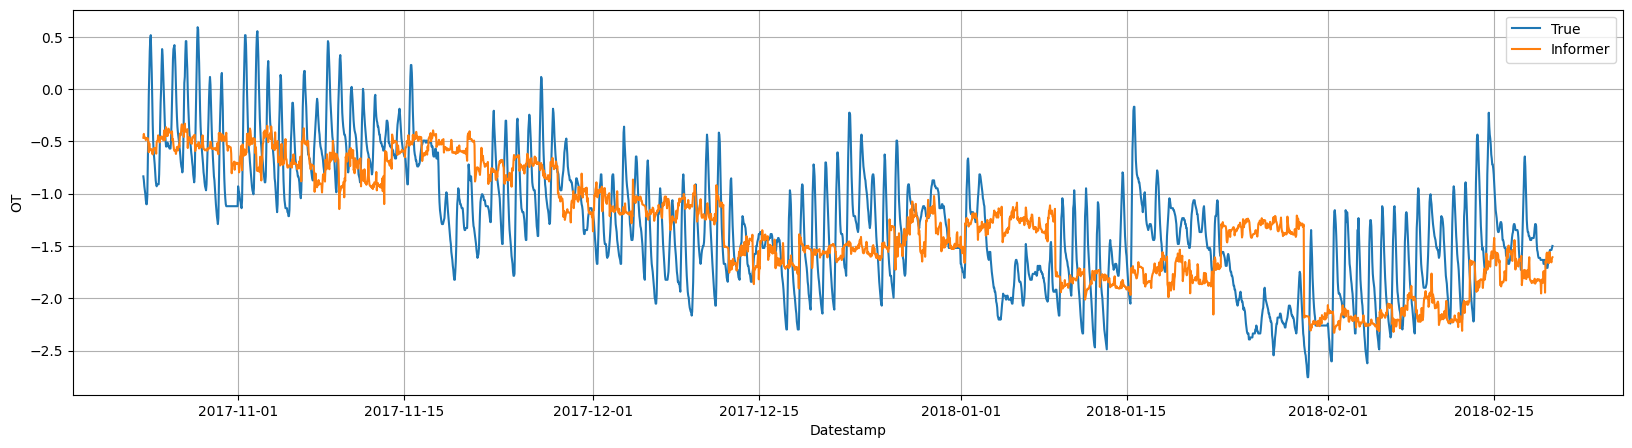

In [6]:
nf, Y_hat_df = train_agent(dataset_group="ETTh2")